# cluster trajectories

In [1]:
import os
import pickle
import time

import numpy as np
import matplotlib.pyplot as plt

import networkx as nx
import umap

from sklearn.cluster import AgglomerativeClustering, HDBSCAN, SpectralClustering
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

/sciclone/geograd/stmorse/dtm/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
base_path = '/sciclone/geograd/stmorse/reddit/mbkm_50'

In [141]:
start_year = 2007
end_year = 2014
start_month = 1
end_month = 12

years = [str(y) for y in range(start_year, end_year+1)]
months = [f'{m:02}' for m in range(start_month, end_month+1)]
yrmo = [(yr, mo) for yr in years for mo in months]

In [142]:
C = []
Ck = 50  # TODO: doesn't need to be the same every month
for year, month in yrmo:
    with open(os.path.join(base_path, f'models/model_cc_{year}-{month}.npz'), 'rb') as f:
        cc = np.load(f)['cc']
        if Ck != cc.shape[0]: print(Ck, cc.shape[0])
        C.append(cc)
C = np.vstack(C)
print(C.shape)

T = []
for year, month in yrmo:
    with open(os.path.join(base_path, f'tfidf/tfidf_{year}-{month}.pkl'), 'rb') as f:
        tfidf = pickle.load(f)
    # TODO: hacky, maybe 'tfidf' shouldn't be a dict
    for j in range(len(tfidf['tfidf'].keys())):
        T.append(tfidf['tfidf'][j]['keywords'])
print(len(T))

(4800, 384)
4800


In [143]:
u_embedder = umap.UMAP(
    n_neighbors=15,
    n_components=10,
    metric='euclidean',
    init='spectral',
    min_dist=0.1,
    spread=1.0
)

Cu = u_embedder.fit_transform(C)
Cu.shape

/sciclone/geograd/stmorse/dtm/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(4800, 10)

In [144]:
Cu2d = umap.UMAP(n_components=2).fit_transform(C)
Cu2d.shape

/sciclone/geograd/stmorse/dtm/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(4800, 2)

## graph

In [7]:
G = nx.Graph()

n = C.shape[0]

for t in range(len(yrmo)):
    for i in range(Ck):
        ix = t*50 + i
        G.add_node(f'u_{t}_{i}',
                   x=Cu2d[ix,0],
                   y=Cu2d[ix,1])

threshold = 0.7

pairwise_distances = squareform(pdist(Cu))
n = Cu.shape[0]
W = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        group_i = i // 50
        topic_i = i % 50
        group_j = j // 50
        topic_j = j % 50
        if abs(group_i - group_j) <= 3:
            W[i,j] = np.exp(-pairwise_distances[i,j]**2 / (2*0.5**2))
            if W[i,j] >= threshold:
                G.add_edge(f'u_{group_i}_{topic_i}', 
                        f'u_{group_j}_{topic_j}', 
                        weight=W[i,j])

connected_components = list(nx.connected_components(G))
len(connected_components)

589

In [8]:
np.unique([len(comp) for comp in connected_components], return_counts=True)

(array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         15,  16,  17,  18,  19,  20,  22,  23,  25,  27,  28,  35,  36,
         37,  38,  40,  44,  49,  56,  62,  63,  68,  80,  87, 113]),
 array([341,  77,  55,  20,  19,  14,   9,   5,   5,   4,   3,   3,   3,
          2,   2,   3,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   2,   1,   2,   1,   1,   1,   1,   1,   1,   1,   1]))

In [9]:
trim_components = [component for component in connected_components if len(component) >= 6]

77


/local/scr/stmorse/TMPDIR/ipykernel_334808/350637049.py:27: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x_coords, y_coords, s=50, c=colors[k], edgecolors='k', zorder=2)


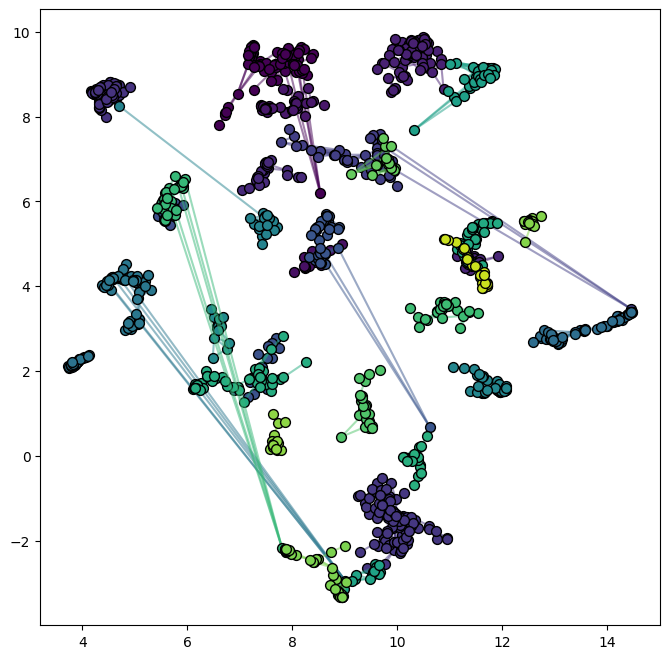

In [22]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

n_clusters = len(trim_components)
print(n_clusters)

colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))

for k, component in enumerate(trim_components):
    if len(component) < 15:
        continue

    # Extract the subgraph
    subgraph = G.subgraph(component)

    # Get positions from node attributes
    pos = {node: (data['x'], data['y']) for node, data in subgraph.nodes(data=True)}

    # Plot edges
    for edge in subgraph.edges(data=True):
        x_coords = [pos[edge[0]][0], pos[edge[1]][0]]
        y_coords = [pos[edge[0]][1], pos[edge[1]][1]]
        ax.plot(x_coords, y_coords, color=colors[k], alpha=0.5)

    # Plot nodes
    x_coords = [pos[node][0] for node in subgraph.nodes()]
    y_coords = [pos[node][1] for node in subgraph.nodes()]
    ax.scatter(x_coords, y_coords, s=50, c=colors[k], edgecolors='k', zorder=2)

    # # Annotate nodes
    # for node, (x, y) in pos.items():
    #     plt.text(x, y, str(node), fontsize=12, ha='center', va='center', zorder=3)

    # # Annotate edge weights
    # for edge in subgraph.edges(data=True):
    #     x_mid = (pos[edge[0]][0] + pos[edge[1]][0]) / 2
    #     y_mid = (pos[edge[0]][1] + pos[edge[1]][1]) / 2
    #     plt.text(x_mid, y_mid, str(edge[2]['weight']), fontsize=10, ha='center', va='center', backgroundcolor='white')

plt.show()

## spectral

In [11]:
pairwise_distances = squareform(pdist(Cu))
n = Cu.shape[0]
W = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        group_i = i // 50
        group_j = j // 50
        if abs(group_i - group_j) <= 3:
            W[i,j] = np.exp(-pairwise_distances[i,j]**2 / (2*0.5**2))
            # W[i,j] = pairwise_distances[i,j]

In [12]:
sc = SpectralClustering(
    n_clusters=100,
    affinity='precomputed',
)
sc.fit(W)

np.unique(sc.labels_, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
       dtype=int32),
 array([ 13,  80,   2,  11,  23,   3,   2,  73,   6,   9,  22, 110,   3,
          5,  39,   4,  12,  10,   7,  10,   8,   6,   6,   5,   8,  38,
         10,  18,  15,  75,  12,  33,  15,  17,  19,  15,  16,  44,   9,
         15,  22,   8,  29,  57,  52,  10,  58,  16,  17,  13,  15,  20,
         14,  11,  11,  14,   8,  17,  31,  31,  16,  37,  43,  13,  27,
         19,  11,  21,   7,  39,  38,  12,  18,  42,  21,  25,  40,  21,
          4,  47,  79,  25,  21,  16,  25,  22,  16,  30,  19,  54,  20,
         36,  19,  

/local/scr/stmorse/TMPDIR/ipykernel_334808/1542184438.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(Cu2d[idx,0], Cu2d[idx,1], s=30, c=colors[k], alpha=0.6, label=k)


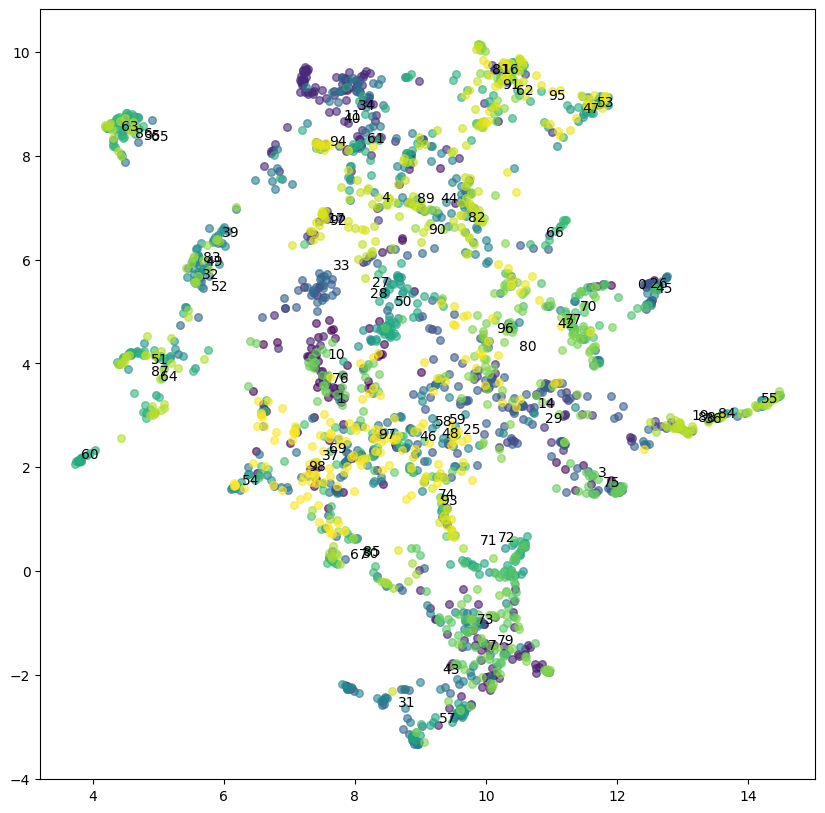

In [14]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

n_clusters = np.amax(sc.labels_)
colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))

for k in range(n_clusters):
    idx = np.where(sc.labels_ == k)[0]
    if len(idx) < 10:
        continue
    
    ax.scatter(Cu2d[idx,0], Cu2d[idx,1], s=30, c=colors[k], alpha=0.6, label=k)

    centroid = np.average(Cu2d[idx,:], axis=0)
    ax.text(centroid[0], centroid[1], k)

plt.show()

## hdbscan

In [145]:
hdbs = HDBSCAN(
    min_cluster_size=5,
    min_samples=None,       # None defaults to min_cluster_size
    cluster_selection_epsilon=0.0,
    max_cluster_size=None,
    metric='euclidean',
    store_centers='both',   # centroid and medoid
)
hdbs.fit(Cu)

np.unique(hdbs.labels_, return_counts=True)

(array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
         12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
         25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
         38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
         51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
         64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
         77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
         90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
        103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
        116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
        129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
        155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 176

/local/scr/stmorse/TMPDIR/ipykernel_334808/1347177552.py:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(Cu2d[idx,0], Cu2d[idx,1], s=30, c=colors[k], alpha=0.6, label=k)


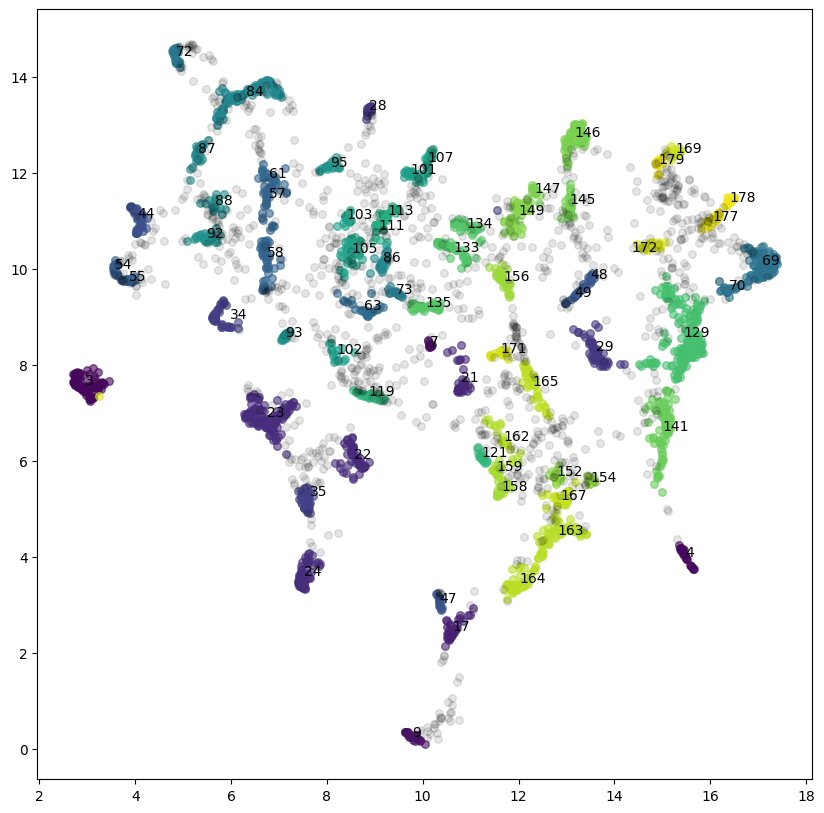

In [148]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

n_clusters = np.amax(hdbs.labels_)
colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))

for k in range(1, n_clusters):
    idx = np.where(hdbs.labels_ == k)[0]

    if len(idx) < 15:
        continue
    
    ax.scatter(Cu2d[idx,0], Cu2d[idx,1], s=30, c=colors[k], alpha=0.6, label=k)

    centroid = np.average(Cu2d[idx,:], axis=0)
    ax.text(centroid[0], centroid[1], k)

# plot uncategorized
idx = np.where(hdbs.labels_ == -1)[0]
ax.scatter(Cu2d[idx, 0], Cu2d[idx, 1], s=30, c='k', alpha=0.1)

plt.show()

In [198]:
coi = 169

idx = np.where(hdbs.labels_ == coi)[0]
for x in idx:
    print(f'{x} ({x // 50}) ({hdbs.probabilities_[x]:.3f}): {T[x][:5]}')

85 (1) (1.000): ['gore' 'obama' 'president' 'candidate' 'presidential']
541 (10) (0.495): ['kucinich' 'paul' 'ron' 'candidates' 'ticket']
601 (12) (1.000): ['obama' 'clinton' 'hillary' 'she' 'her']
625 (12) (1.000): ['mccain' 'romney' 'huckabee' 'republican' 'giuliani']
627 (12) (1.000): ['obama' 'kucinich' 'cfr' 'establishment' 'candidate']
675 (13) (1.000): ['barackobama' 'barack' 'clinton' 'campaign' 'supporter']
681 (13) (1.000): ['clinton' 'hillary' 'michigan' 'mccain' 'delegates']
750 (15) (1.000): ['mccain' 'lieberman' 'vote' 'obama' 'hillary']
780 (15) (1.000): ['obama' 'wright' 'barack' 'campaign' 'clinton']
820 (16) (1.000): ['mccain' 'obama' 'john' 'obamasiah' 'victory']
846 (16) (1.000): ['obama' 'vote' 'clinton' 'hillary' 'supporters']
882 (17) (1.000): ['obama' 'voted' 'roll' '05' 'barack']
960 (19) (1.000): ['mccain' 'obama' 'john' 'supporter' 'pow']
974 (19) (1.000): ['obama' 'fisa' 'barack' 'biden' 'campaign']
1007 (20) (0.874): ['paul' 'ron' 'obama' 'mccain' '08']
104

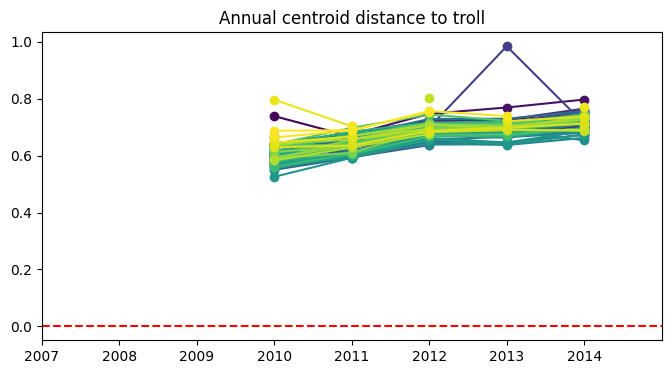

In [156]:
# check if cluster centroids are growing closer to each other
coi_a = 0
title = 'troll'

# coi_bs = [44, 58, 1, 15 ]
labs, cnts = np.unique(hdbs.labels_, return_counts=True)
coi_bs = [i for i, c in zip(labs, cnts) if i != coi_a and i != -1 and c >= 15]
labels = ['politics (D)', 'politics (R)', 'religion', 'market']
colors = plt.cm.viridis(np.linspace(0, 1, len(coi_bs)))

idx_a = np.where(hdbs.labels_==coi_a)[0]

fig, ax = plt.subplots(1,1, figsize=(8,4))

for i, coi_b in enumerate(coi_bs):
    idx_b = np.where(hdbs.labels_==coi_b)[0]

    diffs = []
    for y in range(0, len(years)):
        split_0, split_1 = 12 * 50 * y, 12 * 50 * (y+1)
        sub_a = idx_a[np.where((idx_a >= split_0) & (idx_a < split_1))[0]]
        sub_b = idx_b[np.where((idx_b >= split_0) & (idx_b < split_1))[0]]

        if len(sub_a) == 0 or len(sub_b) == 0:
            diffs.append(0)
            continue

        # compute average centroid
        avg_a = np.mean(C[sub_a], axis=0)
        avg_b = np.mean(C[sub_b], axis=0)

        # compute difference
        diff = np.linalg.norm(avg_a - avg_b)
        diffs.append(diff)

    diffs = np.array(diffs)

    diffs = np.where(diffs == 0, np.nan, diffs)
    ax.plot(range(len(diffs)), diffs, color=colors[i], linestyle='-', marker='o', label=coi_b)
    # ax.text(-0.5, diffs[0], labels[i])

ax.axhline(y=0, color='r', linestyle='--')
ax.set_xlim([0, len(years)])
ax.set_xticks(range(len(years)))
ax.set_xticklabels(range(start_year, end_year+1))
# ax.legend()
ax.set_title(f'Annual centroid distance to {title}')
plt.show()


In [161]:
labs, cnts = np.unique(hdbs.labels_, return_counts=True)
labels_trim = [i for i, c in zip(labs, cnts) if i != -1 and c >= 15]
n = len(labels_trim)

diffs = (-1) * np.ones((5, n, n))
for xy, y in enumerate(range(3, len(years))):
    split_0, split_1 = 12 * 50 * y, 12 * 50 * (y+1)

    for xa in range(n):
        coi_a = labels_trim[xa]
        idx_a = np.where(hdbs.labels_==coi_a)[0]
        sub_a = idx_a[np.where((idx_a >= split_0) & (idx_a < split_1))[0]]

        for xb in range(xa, n):
            coi_b = labels_trim[xb]
            idx_b = np.where(hdbs.labels_==coi_b)[0]
            sub_b = idx_b[np.where((idx_b >= split_0) & (idx_b < split_1))[0]]

            if len(sub_a) == 0 or len(sub_b) == 0:
                diffs[xy,xa,xb] = -1
                continue

            # compute average centroid
            avg_a = np.mean(C[sub_a], axis=0)
            avg_b = np.mean(C[sub_b], axis=0)

            # compute difference
            diff = np.linalg.norm(avg_a - avg_b)
            diffs[xy,xa,xb] = diff

diffs[diffs == -1] = np.nan

change = diffs[1:,:,:] - diffs[:-1,:,:]
print(change.shape)


(4, 70, 70)


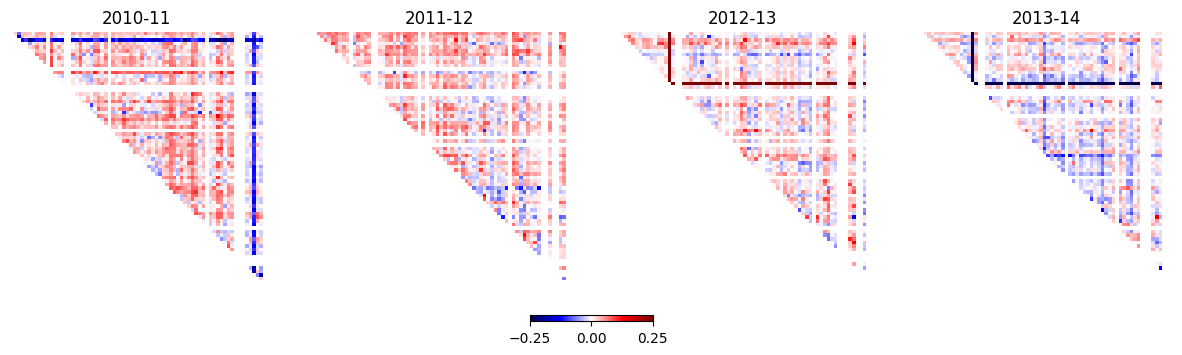

In [174]:
fig, ax = plt.subplots(1,4, figsize=(15,4), sharey=True)

titles = ['2010-11', '2011-12', '2012-13', '2013-14']
for i in range(4):
    cb = ax[i].imshow(change[i,:,:], 
                 cmap='seismic',
                 vmin=-0.25, vmax=0.25)
    
    ax[i].axis('off')
    ax[i].set_title(titles[i])

fig.colorbar(cb, ax=ax, orientation='horizontal', fraction=0.02, pad=0.1)
# plt.tight_layout()
plt.show()

In [185]:
print(change[0,:5,:5])

[[ 0.          0.02335768 -0.07238881  0.02830082  0.03510942]
 [        nan  0.         -0.18090309  0.03442461  0.01825497]
 [        nan         nan  0.         -0.16067962 -0.09863035]
 [        nan         nan         nan  0.          0.00367121]
 [        nan         nan         nan         nan  0.        ]]


In [187]:
labels_trim[2]

np.int64(4)

## comparison to RW

In [ ]:
# generate RW in 384 dim
# project down to 2-d
# compare to cluster centroid movement in 2-d

/sciclone/geograd/stmorse/dtm/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


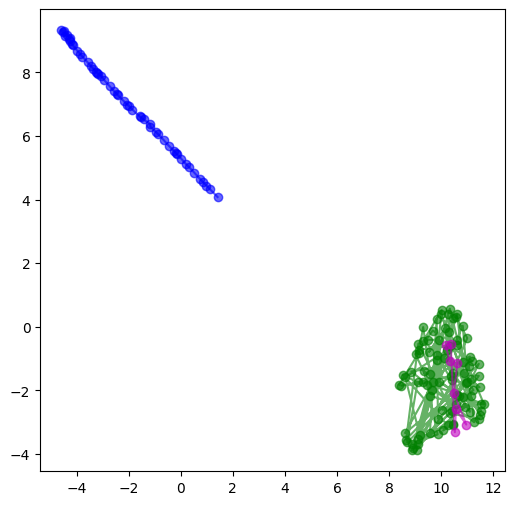

In [177]:
# vars
np.random.seed(314)
d = 384     # dimension
s = 1       # stdev
n = 50      # num steps (time periods)
cois = [3, 14]

# generate RW
steps = np.random.normal(loc=0, scale=s, size=(n, d))
walk = np.cumsum(steps, axis=0)

# get cluster centroids and standardize
clusters = []
lengths = []
for coi in cois:
    idx = np.where((hdbs.labels_==coi) & (hdbs.probabilities_>=0.75))[0]
    lengths.append(len(idx))

    # standardize
    Cm  = C[idx]
    Cm -= np.mean(Cm, axis=0)
    csd = np.std(Cm, axis=0)
    csd[csd == 0] = 1e-8   # gracefully handle any dims that are exact
    Cm /= csd

    clusters.append(Cm)
clusters = np.vstack(clusters)

# put in one matrix
data = np.vstack((
    walk, clusters
))

# dim reduce
data2d = umap.UMAP().fit_transform(data)

# plot
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.plot(data2d[:n,0], data2d[:n,1], 
        color='b', linestyle='-', marker='o', alpha=0.6, label='RW')
ax.plot(data2d[n:(n+lengths[0]),0], data2d[n:(n+lengths[0]),1],
        color='g', linestyle='-', marker='o', alpha=0.6, label=f'Cluster {cois[0]}')
ax.plot(data2d[(n+lengths[0]):,0], data2d[(n+lengths[0]):,1],
        color='m', linestyle='-', marker='o', alpha=0.6, label=f'Cluster {cois[1]}')

# ax.legend()
plt.show()

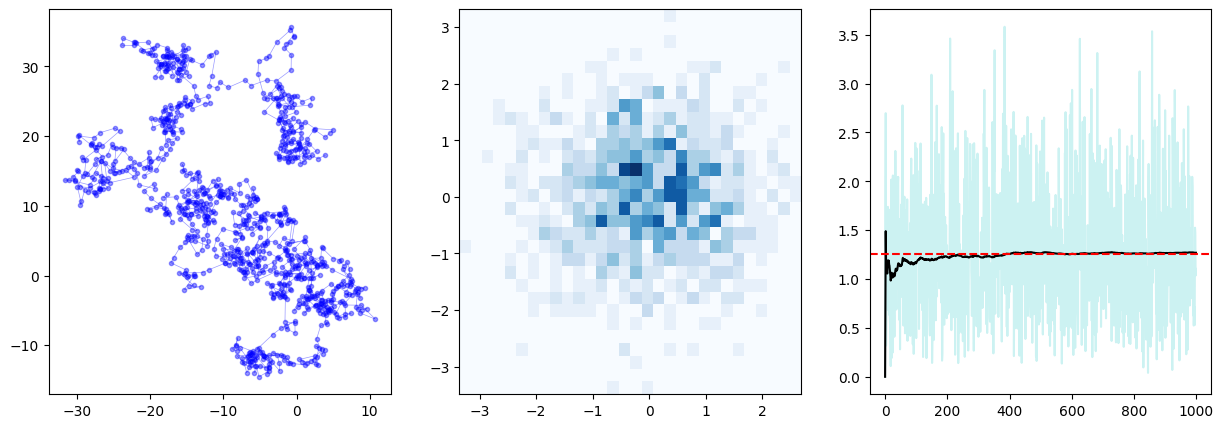

In [60]:
np.random.seed(11)

d = 2
s = 1
cov = s * np.identity(d)
n = 1000

steps = np.random.multivariate_normal([0,0], cov, size=n-1)
steps = np.vstack(([[0,0]], steps))
walk  = np.cumsum(steps, axis=0)

step_sizes = np.linalg.norm(steps, axis=1)

step_size_means = np.cumsum(step_sizes) / np.arange(1, n+1)

mean_steps = np.cumsum(steps, axis=0) / np.arange(1, n+1)[:, None]

fig, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].plot(walk[:,0], walk[:,1], color='b', marker='.', linestyle='-', linewidth=0.5, alpha=0.4)
axs[1].hist2d(steps[:, 0], steps[:, 1], bins=30, cmap='Blues', density=True, cmin=0, cmax=1)

axs[2].plot(range(n), step_sizes, 'c-', alpha=0.2)
axs[2].plot(range(n), step_size_means, 'k-')
m = s * np.sqrt(np.pi / 2)
axs[2].axhline(y=m, color='r', linestyle='--')

plt.show()

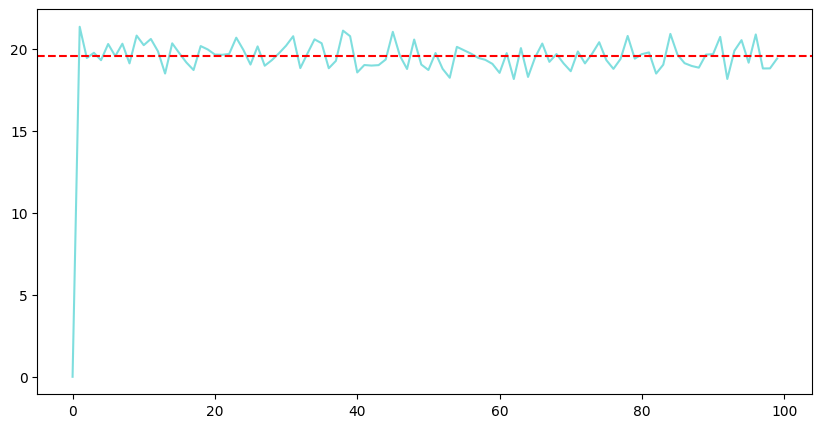

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

# PLOT RW

n = 100
d = 384
mu = np.zeros(d)
cov = 1 * np.identity(d)
steps = np.random.multivariate_normal(mu, cov, size=n-1)
steps = np.vstack((np.zeros((1,d)), steps))
walk  = np.cumsum(steps, axis=0)
step_sizes = np.linalg.norm(steps, axis=1)
ax.plot(range(len(step_sizes)), step_sizes, 'c-', alpha=0.5)

# PLOT CENTROID STEPS

labs, cnts = np.unique(hdbs.labels_, return_counts=True)
labels_trim = [i for i, c in zip(labs, cnts) if i != -1 and c >= 15]
n = len(labels_trim)

# look at mean step sizes and step mean in data
coi = 169

idx = np.where(hdbs.labels_==coi)[0]
steps = C[idx[1:],:] - C[idx[:-1],:]
step_sizes = np.linalg.norm(steps, axis=1)

# ax.plot(range(len(step_sizes)), step_sizes, 'ko-')

p = 1 * np.sqrt(2) * np.sqrt(C.shape[1] / 2)
ax.axhline(y=p, color='r', linestyle='--')

plt.show()

# visualize cluster trajectory

In [6]:
import os
import pickle
import time

import numpy as np
import matplotlib.pyplot as plt

import umap
from sklearn.cluster import AgglomerativeClustering, HDBSCAN, SpectralClustering
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

In [10]:
base_path = '/sciclone/geograd/stmorse/reddit/mbkm_50'

In [3]:
start_year = 2008
end_year = 2009
start_month = 1
end_month = 12

years = [str(y) for y in range(start_year, end_year+1)]
months = [f'{m:02}' for m in range(start_month, end_month+1)]
yrmo = [(yr, mo) for yr in years for mo in months]

In [12]:
C = []
Ck = -1  # TODO: doesn't need to be the same every month
for year, month in yrmo:
    with open(os.path.join(base_path, f'models/model_cc_{year}-{month}.npz'), 'rb') as f:
        cc = np.load(f)['cc']
        Ck = cc.shape[0]
        C.append(cc)
C = np.vstack(C)
print(C.shape)

T = []
for year, month in yrmo:
    with open(os.path.join(base_path, f'tfidf/tfidf_{year}-{month}.pkl'), 'rb') as f:
        tfidf = pickle.load(f)
    # TODO: hacky, maybe 'tfidf' shouldn't be a dict
    for j in range(len(tfidf['tfidf'].keys())):
        T.append(tfidf['tfidf'][j]['keywords'])
print(len(T))

(600, 384)
600


In [7]:
u_embedder = umap.UMAP(
    n_neighbors=15,
    n_components=10,
    metric='euclidean',
    init='spectral',
    min_dist=0.1,
    spread=1.0
)

Cu = u_embedder.fit_transform(C)
Cu.shape

/sciclone/geograd/stmorse/dtm/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(600, 10)

In [26]:
# cluster in the lower space
hdbs = HDBSCAN(
    min_cluster_size=5,
    min_samples=None,       # None defaults to min_cluster_size
    cluster_selection_epsilon=0.0,
    max_cluster_size=None,
    metric='euclidean',
    store_centers='both',   # centroid and medoid
)
hdbs.fit(Cu)
labels = hdbs.labels_
probs  = hdbs.probabilities_

In [27]:
np.unique(labels, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 array([144,  17,  18,   5,  16,  23,  10,  15,   8,  11,   9,  38,   7,
         15,  52,   6,  12,   5,  16,  11,  14,  12,  17,  12,  33,   7,
          6,   8,  19,  28,   6]))

In [30]:
Cu2d = umap.UMAP(n_components=2).fit_transform(C)
print(Cu2d.shape)

/sciclone/geograd/stmorse/dtm/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(600, 2)


/local/scr/stmorse/TMPDIR/ipykernel_3761385/1747021942.py:8: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(Cu2d[idx,0], Cu2d[idx,1], s=30, c=colors[k], alpha=0.6, label=k)


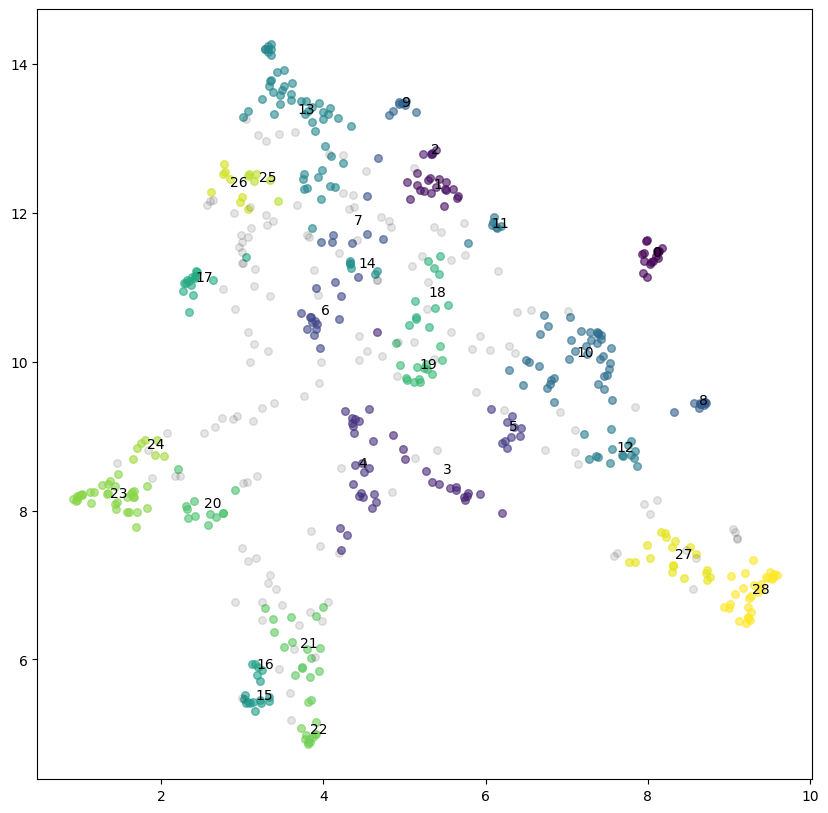

In [32]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

n_clusters = np.amax(labels)
colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))

for k in range(n_clusters):
    idx = np.where(labels == k)[0]
    ax.scatter(Cu2d[idx,0], Cu2d[idx,1], s=30, c=colors[k], alpha=0.6, label=k)

    centroid = np.average(Cu2d[idx,:], axis=0)
    ax.text(centroid[0], centroid[1], k)

# plot uncategorized
idx = np.where(labels == -1)[0]
ax.scatter(Cu2d[idx, 0], Cu2d[idx, 1], s=30, c='k', alpha=0.1)

plt.show()

In [55]:
coi = 27

idx = np.where(labels == coi)[0]
for x in idx:
    print(f'{x} ({x // 50}) ({probs[x]:.3f}): {T[x][:5]}')

24 (0) (1.000): ['subreddit' 'engaged' 'engage' 'engadgets' 'engadget']
51 (1) (1.000): ['nader' 'democrats' 'gore' 'party' 'votes']
74 (1) (1.000): ['voted' 'ballot' 'votes' 'counted' 'count']
87 (1) (0.905): ['mccain' 'john' 'bomb' 'iraq' 'hero']
104 (2) (1.000): ['texas' 'obama' 'hillary' 'ohio' 'clinton']
143 (2) (1.000): ['florida' 'michigan' 'delegates' 'election' 'democratic']
286 (5) (0.942): ['obama' 'mccain' 'cognitive' 'dissonance' 'hillary']
287 (5) (1.000): ['mccain' 'obama' 'vote' 'party' 'lesser']
298 (5) (1.000): ['vote' 'votes' 'poll' 'polls' 'caucus']
332 (6) (1.000): ['obama' 'republicans' 'liberty' 'constitution' 'libertarian']
338 (6) (1.000): ['vote' 'voting' 'parties' 'candidate' 'election']
414 (8) (0.905): ['palin' 'mccain' 'obama' 'debate' 'she']
444 (8) (1.000): ['republican' 'republicans' 'democrat' 'liberal' 'democrats']
450 (9) (1.000): ['fox' 'republican' 'republicans' 'democrats' 'conservatives']
456 (9) (1.000): ['party' 'voting' 'barr' 'candidate' 'thi

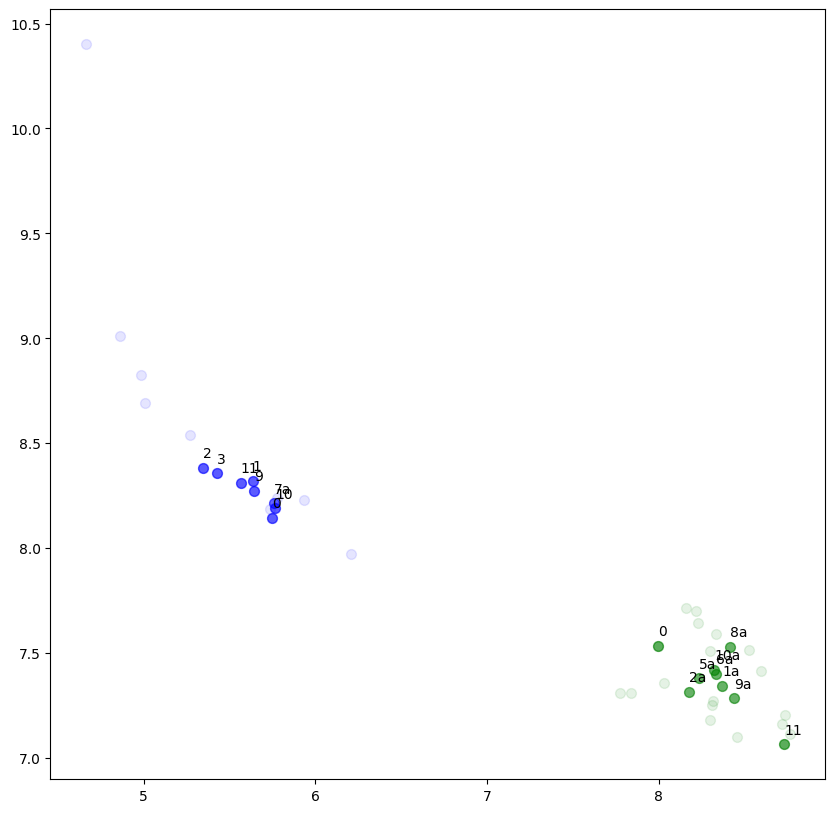

In [65]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

cois = [3, 27]
colors = ['b', 'g']

for coi, color in zip(cois, colors):
    idx = np.where(labels == coi)[0]
    idx_p = np.where((labels == coi) & (probs > 0.7))[0]

    ax.scatter(Cu2d[idx,0], Cu2d[idx,1], s=50, c=color, alpha=0.1)
    # ax.scatter(Cu2d[idx_p,0], Cu2d[idx_p,1], s=50, c=color, alpha=0.6)

    # create version of idx that is the time period
    # [0, 0, 1, 1, 1, 5, 6, 7, 8, 8]
    idx2 = idx_p // 50

    # iterate over entire time period
    for t in range(12):
        # get locations in idx for this time period
        idx3 = np.where(idx2 == t)[0]
        # print(idx3)
        if len(idx3) == 0:
            continue

        avgs = np.average(Cu2d[idx_p[idx3],:], axis=0)

        # ax.plot(Cu2d[idx_p[idx3],0], Cu2d[idx_p[idx3],1], color=color, linestyle='-', alpha=0.6)
        # ax.text(Cu2d[idx_p[idx3[0]],0], Cu2d[idx_p[idx3[0]],1] + 0.05, f'{t}')
        ax.scatter(avgs[0], avgs[1], s=50, color=color, alpha=0.6)
        txt = str(t) if len(idx3) == 1 else f'{t}a'
        ax.text(avgs[0], avgs[1]+0.05, txt)

plt.show()

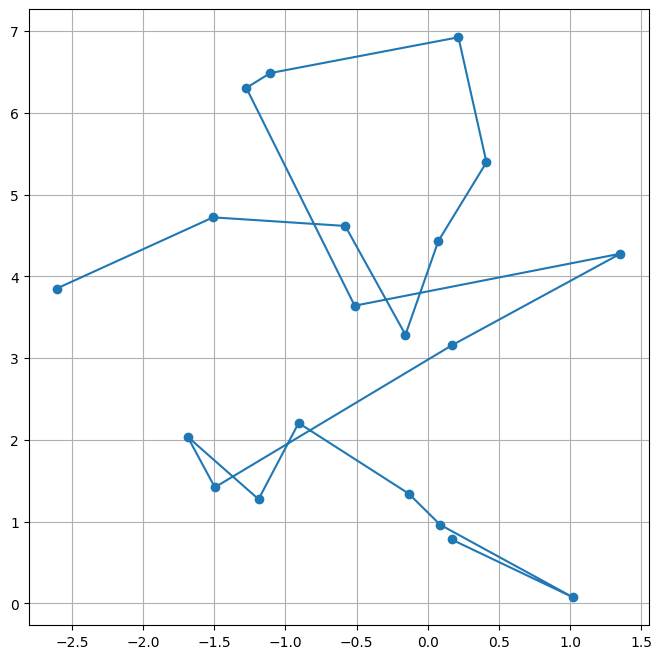

In [57]:
# Generate 20 points from a random walk in 2-d
np.random.seed(314)  # for reproducibility
n_points = 20
steps = np.random.randn(n_points, 2)
random_walk = np.cumsum(steps, axis=0)

# Plot the random walk
plt.figure(figsize=(8,8))
plt.plot(random_walk[:, 0], random_walk[:, 1], marker='o')
plt.grid(True)
plt.show()

In [72]:
import scipy.special as sp

In [81]:
np.random.seed(315)  # for reproducibility
n_points = 10000
sd = 1

# steps = np.random.randn(n_points, 2)
steps = np.random.normal(loc=0, scale=sd, size=(n_points, 2))
walk = np.cumsum(steps, axis=0)

# compute step sizes
steps = np.diff(walk, axis=0)
step_sizes = np.linalg.norm(steps, axis=1)  # Magnitudes of steps
mean_step_size = np.mean(step_sizes)

print(mean_step_size)

# E[mean step size] = sigma * sqrt(2) * Gam(d+1 / 2) / Gam(d / 2)
d = 2
print(sd * np.sqrt(2) * sp.gamma((d+1) / 2) / sp.gamma(d / 2))

# Compute displacements
displacements = walk - walk[0]
displacement_magnitudes = np.linalg.norm(displacements, axis=1)
mean_displacement = np.mean(displacement_magnitudes)

print(f'\nMean displ: {mean_displacement}')
print(f'Final displ: {np.linalg.norm(walk[-1] - walk[0])}')

# E[final displacement] = sigma * sqrt(2 * n / d) * gamma stuff
# check ref
print(sd * np.sqrt(2 * n_points) * sp.gamma((d+1) / 2) / sp.gamma(d / 2))

1.2369810186567327
1.2533141373155003

Mean displ: 93.3170982226291
Final displ: 185.19281363513917
125.33141373155001


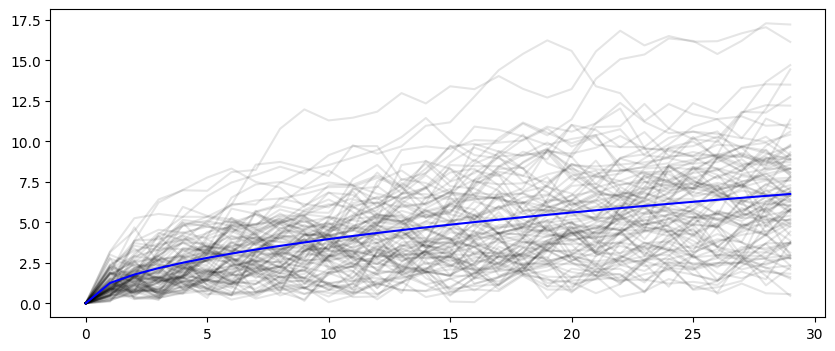

In [86]:
m = 100  # num random walks
d = 2    # dimension
s = 1    # standard deviation
n = 30   # num points

fig, ax = plt.subplots(1,1, figsize=(10,4))

for i in range(m):
    steps = np.random.normal(loc=0, scale=1, size=(n, d))
    walk = np.cumsum(steps, axis=0)
    
    displacements = walk - walk[0]
    displacement_magnitudes = np.linalg.norm(displacements, axis=1)
    
    ax.plot(range(n), displacement_magnitudes, 'k-', alpha=0.1)

theoretical_magnitudes = sd * np.sqrt(2 * np.arange(n)) * \
        sp.gamma((d+1) / 2) / sp.gamma(d / 2)
ax.plot(range(n), theoretical_magnitudes, 'b-')

plt.show()

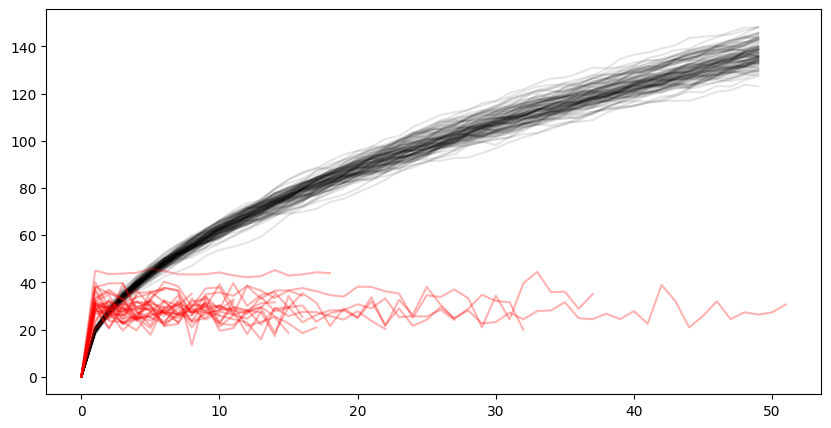

In [100]:
# generate random walks in 384 dimensions
# compare displacement to actual aligned clusters

def get_displacement_mags(seq):
    displacements = seq - seq[0]
    return np.linalg.norm(displacements, axis=1)

fig, ax = plt.subplots(1,1, figsize=(10,5))

# plot RWs
m = 100
d = 384
s = 1
n = 50

for i in range(m):
    steps = np.random.normal(loc=0, scale=1, size=(n, d))
    walk = np.cumsum(steps, axis=0)
    
    displacements = walk - walk[0]
    displacement_magnitudes = np.linalg.norm(displacements, axis=1)
    
    ax.plot(range(n), displacement_magnitudes, 'k-', alpha=0.1)

# plot cluster
for coi in range(np.amax(labels)):
    idx = np.where(labels == coi)[0]
    coi_data = C[idx,:]

    # standardize
    coi_data -= np.mean(coi_data, axis=0)
    stdev = np.std(coi_data, axis=0)
    stdev[stdev == 0] = 1e-8
    coi_data /= stdev

    ax.plot(range(coi_data.shape[0]), get_displacement_mags(coi_data), 'r-', alpha=0.3)

# theoretical_magnitudes = s * np.sqrt(2 * np.arange(n)) * \
#         sp.gamma((d+1) / 2) / sp.gamma(d / 2)
# ax.plot(range(n), theoretical_magnitudes, 'b-')

plt.show()

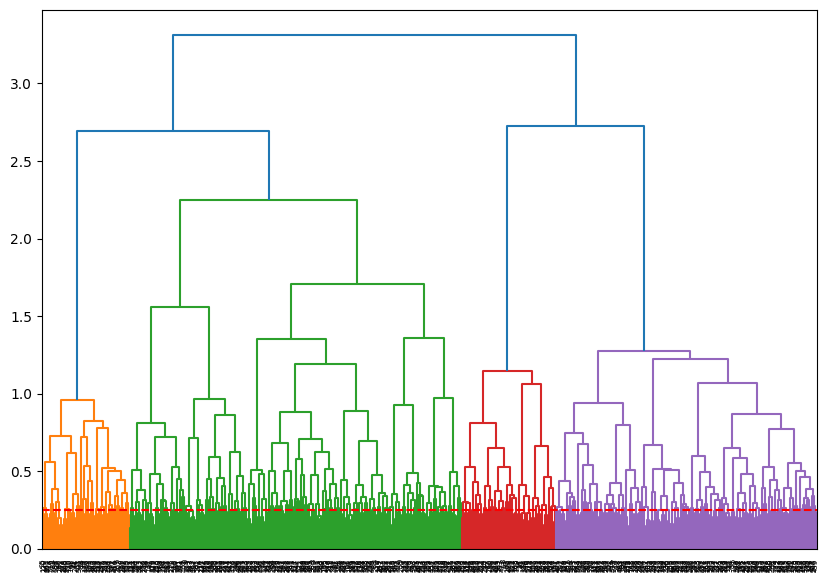

In [10]:
Z = linkage(C, 'ward')
fig = plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.axhline(y=0.25, color='r', linestyle='--')
# fig.savefig('dendrogram.png', dpi=fig.dpi)  
plt.show()

In [30]:
ahc = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=0.4,
    linkage='ward',
)
ahc.fit(C)
ahc.n_clusters_

108

In [15]:
# embed all centroids in 2-d
tsne = TSNE(
    n_components=2,
    perplexity=30,
    early_exaggeration=12,
)
CT = tsne.fit_transform(C)

In [31]:
# find a cluster with at least 10 entries
ccounts = np.unique(ahc.labels_, return_counts=True)
ccounts

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107]),
 array([ 7,  6,  9, 11, 11, 10,  6,  7,  9,  9,  6,  5,  5,  8,  4,  5,  8,
         9,  7,  8,  9, 10, 11,  5,  5,  8,  9,  7,  5,  5,  7,  7,  8,  3,
         7,  5,  6,  8,  5, 10,  7,  5,  8,  5,  4,  7,  5,  5,  3,  5,  6,
         3,  5,  4,  7,  4,  8,  4,  4,  8,  6,  4,  4,  8, 11,  1,  3,  2,
         3,  8,  3,  6,  1,  5,  6,  6,  1,  3,  6,  3,  6,  4,  4,  2,  8,
      

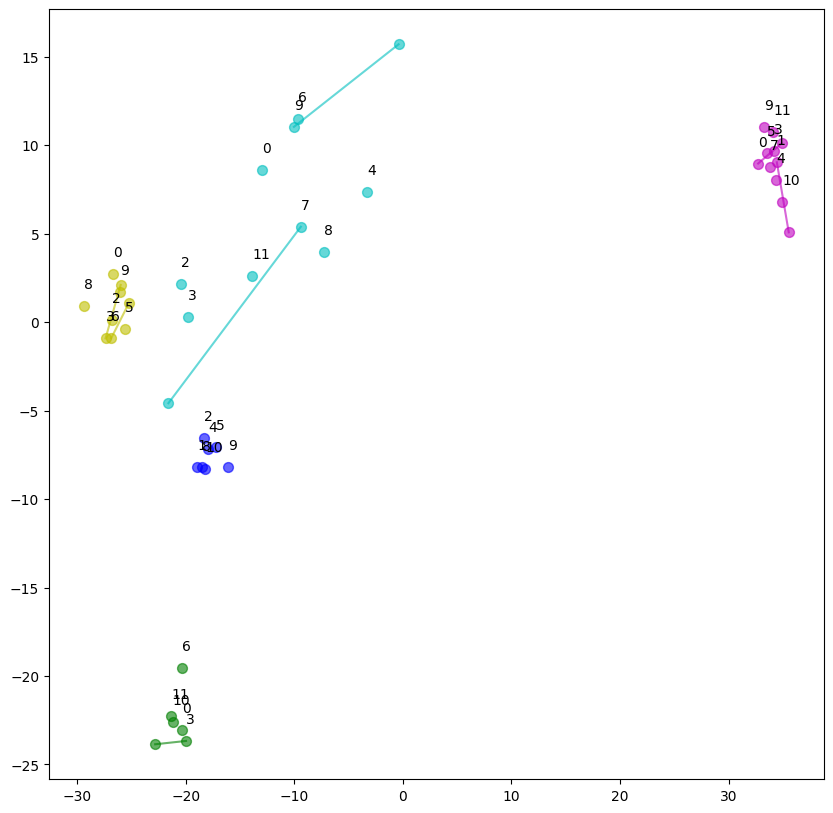

In [32]:
# cluster of interest
cois = [0, 1, 2, 3, 4, 5]
cols = ['b', 'g', 'y', 'c', 'm']

fig, ax = plt.subplots(1,1, figsize=(10,10))

for coi, col in zip(cois, cols):
    idx = np.where(ahc.labels_ == coi)[0]
    ax.scatter(CT[idx,0], CT[idx,1], s=50, c=col, alpha=0.6)

    # for x in idx:
    #     ax.text(CT[x,0], CT[x,1]+1, f'{x // 50}')

    idx2 = idx // 50
    for t in range(CT.shape[0]):
        idx3 = np.where(idx2 == t)[0]
        if len(idx3) == 0:
            continue

        ax.plot(CT[idx[idx3], 0], CT[idx[idx3], 1], color=col, linestyle='-', alpha=0.6)
        ax.text(CT[idx[idx3[0]], 0], CT[idx[idx3[0]], 1]+1, f'{t}')

plt.show()

In [46]:
pairwise_distances = squareform(pdist(C))
n = C.shape[0]
W = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        group_i = i // 50
        group_j = j // 50
        if abs(group_i - group_j) <= 4:
            # W[i,j] = np.exp(-pairwise_distances[i,j]**2 / (2*0.5**2))
            W[i,j] = pairwise_distances[i,j]

In [47]:
sc = SpectralClustering(
    n_clusters=50,
    affinity='precomputed',
)
labels = sc.fit_predict(W)

np.unique(labels, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       dtype=int32),
 array([26, 17, 12, 16,  9, 24, 23, 27,  8,  5, 25, 14, 13,  8,  5, 11,  4,
         7, 10,  6, 16, 13, 25,  2,  4, 15,  3,  4,  8,  9, 13,  9,  5,  7,
         3, 27, 29, 10,  8,  2,  7, 12,  5, 13, 14, 11,  8, 13, 13, 22]))

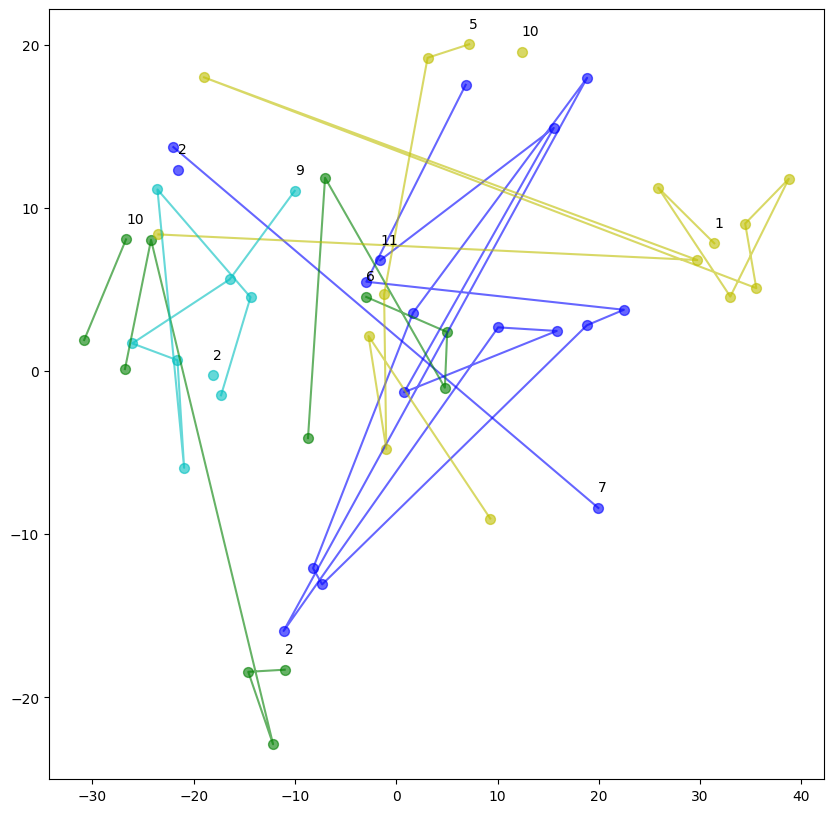

In [48]:
# cluster of interest
cois = [1, 2, 3, 4]
cols = ['b', 'g', 'y', 'c']

fig, ax = plt.subplots(1,1, figsize=(10,10))

for coi, col in zip(cois, cols):
    idx = np.where(labels == coi)[0]
    ax.scatter(CT[idx,0], CT[idx,1], s=50, c=col, alpha=0.6)

    # for x in idx:
    #     ax.text(CT[x,0], CT[x,1]+1, f'{x // 50}')

    idx2 = idx // 50
    for t in range(CT.shape[0]):
        idx3 = np.where(idx2 == t)[0]
        if len(idx3) == 0:
            continue

        ax.plot(CT[idx[idx3], 0], CT[idx[idx3], 1], color=col, linestyle='-', alpha=0.6)
        ax.text(CT[idx[idx3[0]], 0], CT[idx[idx3[0]], 1]+1, f'{t}')

plt.show()

# Bipartite graph test

In [3]:
import networkx as nx

In [6]:
G = nx.Graph()

n = 4

U = [f'u{i}' for i in range(n)]
V = [f'v{i}' for i in range(n)]
G.add_nodes_from(U, bipartite=0)
G.add_nodes_from(V, bipartite=1)

B = np.array([
    [0, 0.4, 0, 0.01],
    [0, 0.8, 0, 0.02],
    [0.9, 0, 0, 0],
    [0.1, 0, 0.1, 0.85]
])

threshold = 0.1

for i in range(B.shape[0]):
    for j in range(B.shape[1]):
        if B[i,j] >= threshold:
            G.add_edge(U[i], V[j])

connected_components = list(nx.connected_components(G))

for i, component in enumerate(connected_components):
    print(f'{i}: {component}')

0: {'v1', 'u1', 'u0'}
1: {'u3', 'v3', 'v0', 'v2', 'u2'}
